本代码主要参考官方baseline:
https://tianchi.aliyun.com/competition/entrance/531858/forum

In [1]:
## 基础工具
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
from IPython.display import display, clear_output
import time

warnings.filterwarnings('ignore')
%matplotlib inline

## 数据处理
from sklearn import preprocessing

## 数据降维处理的
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA

## 模型预测的
import lightgbm as lgb
import xgboost as xgb

## 参数搜索和评价的
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
path = './input/'
## 1) 载入训练集和测试集；
Train_data = pd.read_csv(path+'car_train_0110.csv', sep=' ')
TestA_data = pd.read_csv(path+'car_testA_0110.csv', sep=' ')

## 输出数据的大小信息
print('Train data shape:',Train_data.shape)
print('TestA data shape:',TestA_data.shape)

Train data shape: (250000, 40)
TestA data shape: (50000, 39)


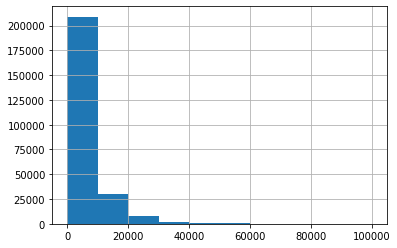

In [3]:
Train_data.price.hist()

In [4]:
#预处理函数
def reduce_mem(df): 
    """ iterate through all the columns of a dataframe and modify the data type  to reduce memory usage.             """ 
    start_mem = df.memory_usage().sum() / 1024**2 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem)) 
    df1 = df.copy() 
    for col in df.columns: 
        col_type = df[col].dtype 
         
        if col_type != object: 
            c_min = df[col].min() 
            c_max = df[col].max() 
            if str(col_type)[:3] == 'int': 
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max: 
                    df[col] = df[col].astype(np.int8) 
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max: 
                    df[col] = df[col].astype(np.int16) 
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max: 
                    df[col] = df[col].astype(np.int32) 
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max: 
                    df[col] = df[col].astype(np.int64)   
            else: 
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max: 
                    df[col] = df[col].astype(np.float16) 
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max: 
                    df[col] = df[col].astype(np.float32) 
                else: 
                    df[col] = df[col].astype(np.float64) 
        #Treatment for category columns
        else: 
            df[col] = df[col].astype('category') 
 
    end_mem = df.memory_usage().sum() / 1024**2 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem)) 
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem)) 
    if end_mem > start_mem:
        print(f'Memory usage increases! Return the original df.')
        return df1
    return df 

In [5]:
Train_data = reduce_mem(Train_data)
TestA_data = reduce_mem(TestA_data)

Memory usage of dataframe is 76.29 MB
Memory usage after optimization is: 20.74 MB
Decreased by 72.8%
Memory usage of dataframe is 14.88 MB
Memory usage after optimization is: 3.96 MB
Decreased by 73.4%


In [6]:
## 通过.head() 简要浏览读取数据的形式
display(Train_data.head())
display(TestA_data.head())

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,regionCode,seller,offerType,creatDate,price,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,v_15,v_16,v_17,v_18,v_19,v_20,v_21,v_22,v_23
0,134890,734,20160002,13.0,9,NaN,0.0,1.0,0,15.0,NaN,725,1,0,20160316,520,60.5625,16.671875,1.416992,1.652344,-11.867188,-0.456787,9.085938,0.566895,0.000000,1.124023,0.000000,0.054291,0.053497,0.124329,0.092163,0.000000,18.765625,-1.511719,-1.008789,-12.101562,-0.947266,9.078125,0.581055,3.945312
1,306648,196973,20080307,72.0,9,7.0,5.0,1.0,173,15.0,1.0,2568,1,0,20160311,5500,73.0000,-4.179688,-0.656250,-3.021484,-0.419434,-1.417969,-3.736328,4.558594,0.314453,0.081787,0.086365,0.134644,0.055450,0.122986,0.001070,0.122314,-5.687500,-0.489990,-2.224609,-0.226807,-0.658203,-3.949219,4.593750,-1.145508
2,340675,25347,20020312,18.0,12,3.0,0.0,1.0,50,12.5,1.0,724,1,0,20160323,1100,69.8125,-4.199219,0.025879,2.769531,-0.645020,1.100586,2.593750,-0.873535,0.315918,0.073792,0.081787,0.085144,0.053528,0.123413,0.064392,0.003345,-3.294922,1.816406,3.554688,-0.683594,0.971680,2.625000,-0.852051,-1.246094
3,57332,5382,20000611,38.0,8,7.0,0.0,1.0,54,15.0,1.0,498,1,0,20160330,1200,69.8125,-4.378906,-0.595703,3.841797,0.119080,1.519531,2.955078,-0.814941,0.315430,0.078308,0.086731,0.076416,0.053528,0.123474,0.069214,0.000000,-3.406250,1.498047,4.781250,0.039093,1.227539,3.041016,-0.801758,-1.251953
4,265235,173174,20030109,87.0,0,5.0,5.0,1.0,131,3.0,1.0,1273,1,0,20160307,3300,73.0625,-3.179688,-0.447021,1.324219,-0.233521,-1.135742,-3.294922,-1.981445,0.315430,0.121277,0.087646,0.138062,0.055634,0.122925,0.000099,0.001656,-4.476562,0.124146,1.364258,-0.319824,-1.131836,-3.302734,-1.998047,-1.279297


,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,regionCode,seller,offerType,creatDate,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,v_15,v_16,v_17,v_18,v_19,v_20,v_21,v_22,v_23
0,720326,505,20060505,19.0,13,7.0,0.0,1.0,90,8.0,1.0,479,1,0,20160402,73.5625,-4.378906,-0.051392,-2.531250,0.145752,2.140625,3.324219,4.031250,0.314697,0.100708,0.086426,0.089417,0.053314,0.122986,0.083313,0.105408,-6.000000,0.147095,-1.903320,0.348877,2.324219,3.343750,4.046875,-1.431641
1,714316,1836,20010301,5.0,5,3.0,4.0,1.0,75,15.0,1.0,1312,1,0,20160323,70.1875,-3.949219,0.551758,2.400391,-0.082825,1.447266,3.500000,-1.193359,0.315430,0.084351,0.081909,0.083374,0.051422,0.123413,0.074463,0.000000,-3.287109,2.082031,2.937500,-0.123047,1.202148,3.570312,-1.180664,-1.348633
2,704693,212291,20170610,6.0,18,NaN,5.0,0.0,150,15.0,0.0,4187,1,0,20160322,68.0000,3.242188,9.953125,-0.249512,-13.078125,-4.574219,-0.487793,-1.722656,0.289551,0.217896,0.000000,0.138916,0.055603,0.130737,0.002031,0.000000,4.367188,8.250000,-4.136719,-13.335938,-4.445312,-0.707031,-1.720703,3.568359
3,624972,1345,19820005,215.0,32,7.0,0.0,1.0,0,6.0,0.0,7023,1,0,20160309,69.0000,-3.689453,-1.526367,2.986328,0.334229,2.916016,5.226562,6.058594,0.288086,0.150879,0.086670,0.036407,0.053314,0.123535,0.098816,0.100891,-2.537109,0.514160,4.414062,0.357666,2.701172,5.324219,6.085938,-0.900391
4,669753,1428,20060205,30.0,4,7.0,5.0,1.0,122,15.0,1.0,5977,1,0,20160308,74.3750,-4.113281,-0.301025,-1.512695,-0.444824,2.349609,4.082031,-2.570312,0.315430,0.117249,0.086792,0.108948,0.055664,0.123108,0.088379,0.002508,-6.199219,-0.191772,-1.224609,-0.326904,2.255859,4.183594,-2.574219,0.014206


In [10]:
#提取数值类型特征列名
numerical_cols = Train_data.select_dtypes(exclude = 'object').columns
print(numerical_cols)
categorical_cols = Train_data.select_dtypes(include = 'object').columns
print(categorical_cols)

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3',
       'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14', 'v_15', 'v_16', 'v_17', 'v_18', 'v_19', 'v_20', 'v_21',
       'v_22', 'v_23'],
      dtype='object')
Index([], dtype='object')


In [11]:
Train_data['notRepairedDamage'].fillna(-1,inplace=True)
TestA_data['notRepairedDamage'].fillna(-1,inplace=True)

In [12]:
date_features = ['regDate', 'creatDate']
numeric_features = ['power', 'kilometer'] + ['v_{}'.format(i) for i in range(15)]
categorical_features = ['name', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox', 'notRepairedDamage', 'regionCode',]

In [13]:
from tqdm import tqdm
#时间特征处理
def date_proc(x):
    m = int(x[4:6])
    if m == 0:
        m = 1
    return x[:4] + '-' + str(m) + '-' + x[6:]

def num_to_date(df,date_cols):
    for f in tqdm(date_cols):
        df[f] = pd.to_datetime(df[f].astype('str').apply(date_proc))
        df[f + '_year'] = df[f].dt.year
        df[f + '_month'] = df[f].dt.month
        df[f + '_day'] = df[f].dt.day
        df[f + '_dayofweek'] = df[f].dt.dayofweek
    return df
Train_data = num_to_date(Train_data,date_features)
TestA_data = num_to_date(TestA_data,date_features)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.76it/s]


时间特征相似，所以可以采用

In [17]:
from scipy.stats import mode
#类别统计
def sta_cate(df,cols):
    sta_df = pd.DataFrame(columns = ['column','nunique','miss_rate','most_value','most_value_counts','max_value_counts_rate'])
    for col in cols:
        count = df[col].count()
        nunique = df[col].nunique()
        miss_rate = (df.shape[0] - count) / df.shape[0]
        most_value = df[col].value_counts().index[0]
        most_value_counts = df[col].value_counts().values[0]
        max_value_counts_rate = most_value_counts / df.shape[0]
        
        sta_df = sta_df.append({'column':col,'nunique':nunique,'miss_rate':miss_rate,'most_value':most_value,
                                'most_value_counts':most_value_counts,'max_value_counts_rate':max_value_counts_rate},ignore_index=True)
    return sta_df 

In [18]:
sta_cate(Train_data,categorical_features)

,column,nunique,miss_rate,most_value,most_value_counts,max_value_counts_rate
0,name,164312,0.000000,451,452,0.001808
1,model,251,0.000000,0,20344,0.081376
2,brand,40,0.000000,0,53699,0.214796
3,bodyType,8,0.101520,7,64571,0.258284
4,fuelType,7,0.089960,0,150664,0.602656
5,gearbox,2,0.054052,1,184645,0.738580
6,notRepairedDamage,3,0.000000,1,176922,0.707688
7,regionCode,8081,0.000000,487,550,0.002200


In [19]:
sta_cate(TestA_data,categorical_features)

,column,nunique,miss_rate,most_value,most_value_counts,max_value_counts_rate
0,name,38668,0.00000,73,98,0.00196
1,model,249,0.00000,0,3916,0.07832
2,brand,40,0.00000,0,10697,0.21394
3,bodyType,8,0.10220,7,12748,0.25496
4,fuelType,7,0.08804,0,30045,0.60090
5,gearbox,2,0.05426,1,36935,0.73870
6,notRepairedDamage,3,0.00000,1,35555,0.71110
7,regionCode,7078,0.00000,487,122,0.00244


In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

def cate_encoder(df,df_test,cols):
    le = LabelEncoder()
    ohe = OneHotEncoder(sparse=False,categories ='auto')
    
    for col in cols:
        print(col+':')
        print(set(df[col]))
        print(set(df_test[col]))
        
        le = le.fit(df[col])
        integer_encoded = le.transform(df[col])
        integer_encoded_test = le.transform(df_test[col])

        # binary encode
        integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
        integer_encoded_test = integer_encoded_test.reshape(len(integer_encoded_test), 1)
        ohe = ohe.fit(integer_encoded)
        
        onehot_encoded = ohe.transform(integer_encoded)
        onehot_encoded_df = pd.DataFrame(onehot_encoded)
        onehot_encoded_df.columns = list(map(lambda x:str(x)+'_'+col,onehot_encoded_df.columns.values))

        onehot_encoded_test = ohe.transform(integer_encoded_test)
        onehot_encoded_test_df = pd.DataFrame(onehot_encoded_test)
        onehot_encoded_test_df.columns = list(map(lambda x:str(x)+'_'+col,onehot_encoded_test_df.columns.values))
        
        df =  pd.concat([df,onehot_encoded_df], axis=1)
        df_test =  pd.concat([df_test,onehot_encoded_test_df], axis=1)
    
    return df,df_test
cate_cols = ['bodyType', 'fuelType', 'gearbox', 'notRepairedDamage']
Train_data[cate_cols] = Train_data[cate_cols].fillna(-1)
TestA_data[cate_cols] = TestA_data[cate_cols].fillna(-1)
Train_data,TestA_data = cate_encoder(Train_data,TestA_data,cate_cols)


bodyType:
{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, -1.0}
{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, -1.0}
fuelType:
{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, -1.0}
{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, -1.0}
gearbox:
{0.0, 1.0, -1.0}
{0.0, 1.0, -1.0}
notRepairedDamage:
{0.0, 1.0, -1.0}
{0.0, 1.0, -1.0}


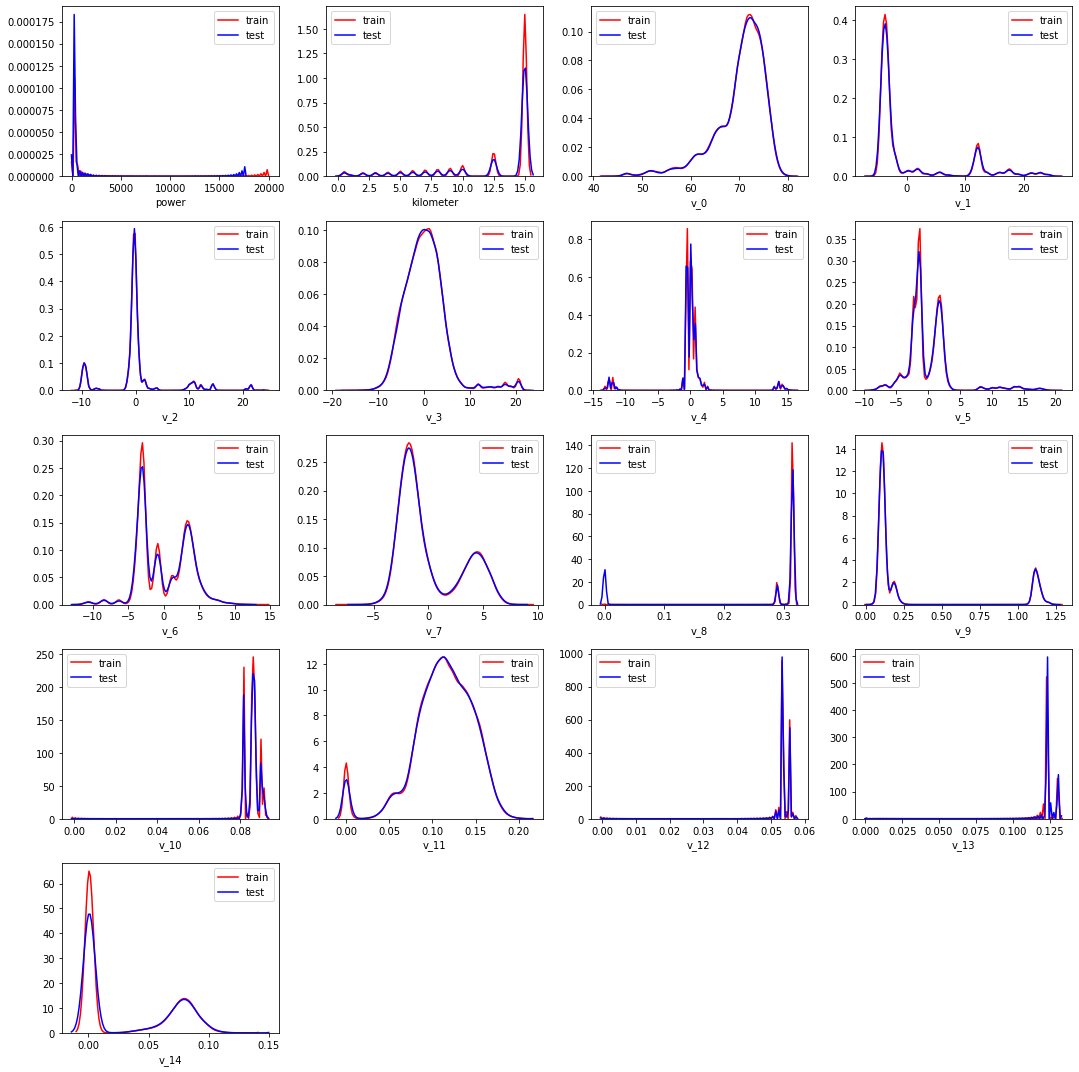

In [23]:
plt.figure(figsize=(15, 15))
i = 1
for col in numeric_features:
    plt.subplot(5, 4, i)
    i += 1
    sns.distplot(Train_data[col], label='train', color='r', hist=False)
    sns.distplot(TestA_data[col], label='test', color='b', hist=False)
plt.tight_layout()
plt.show()

In [24]:
tr = Train_data.copy()
te = TestA_data.copy()

In [47]:
Train_data.kilometer

0         15.0
1         15.0
2         12.5
3         15.0
4          3.0
          ... 
249995    15.0
249996    15.0
249997     3.0
249998     9.0
249999    12.5
Name: kilometer, Length: 250000, dtype: float16

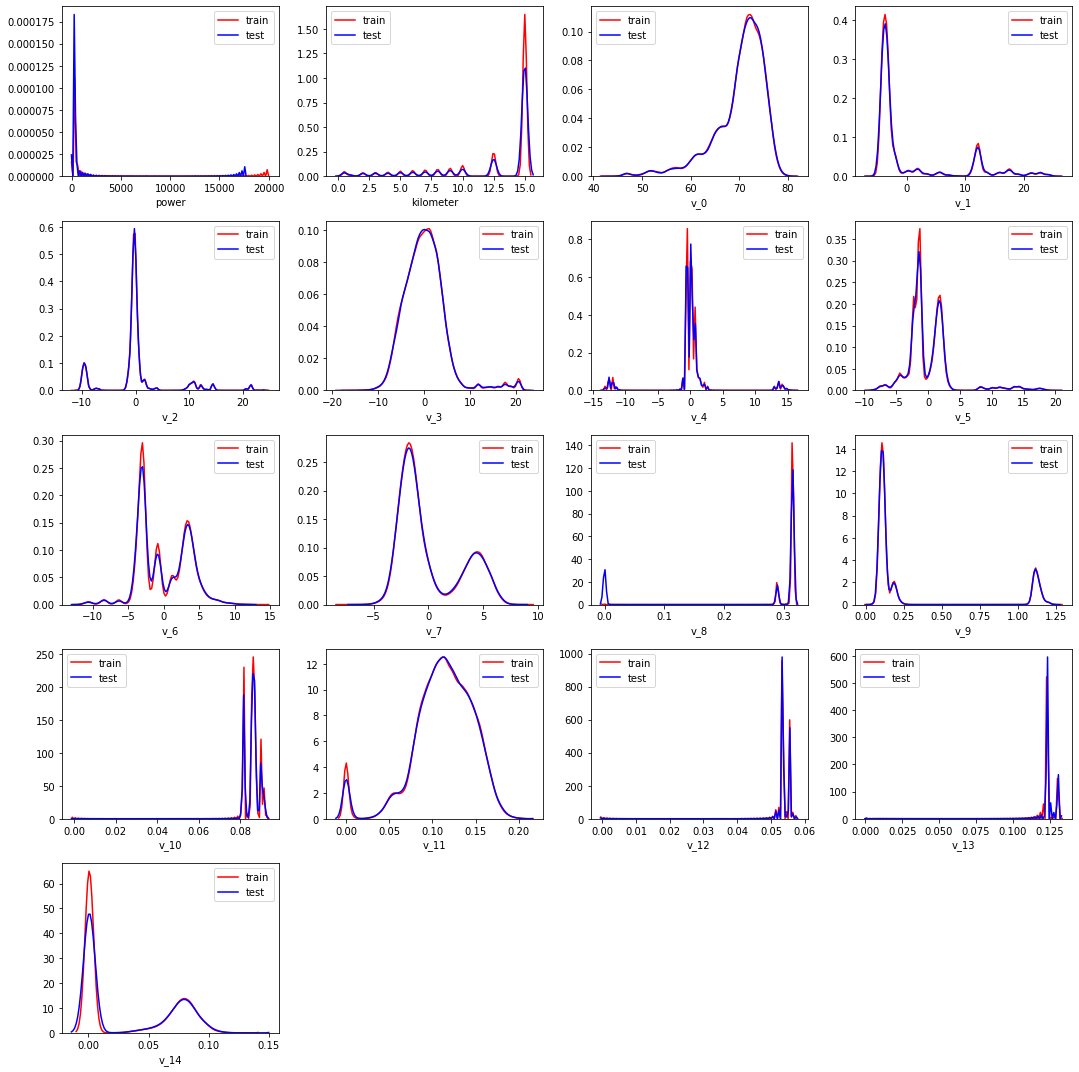

In [26]:
plt.figure(figsize=(15, 15))
i = 1
for col in numeric_features:
    plt.subplot(5, 4, i)
    i += 1
    sns.distplot(Train_data[col], label='train', color='r', hist=False)
    sns.distplot(TestA_data[col], label='test', color='b', hist=False)
plt.tight_layout()
plt.show()

# 特征工程

In [27]:
# 训练集和测试集放在一起，方便构造特征
Train_data['train']=1
TestA_data['train']=0

data = pd.concat([Train_data, TestA_data], ignore_index=True, sort=False)

In [ ]:
data['used_time'] = (pd.to_datetime(data['creatDate'], format='%Y%m%d', errors='coerce') - 
                            pd.to_datetime(data['regDate'], format='%Y%m%d', errors='coerce')).dt.days

# 看一下空数据，有 15k 个样本的时间是有问题的，我们可以选择删除，也可以选择放着（不管或者作为一个单独类别）。
# XGBoost 之类的决策树，其本身就能处理缺失值，所以可以不用管；
data['used_time'].isnull().sum()

In [29]:
## 由于power 特征的分布特性，这里对于其进行log变化
data['power'] = np.log1p(data['power'])

In [30]:
#聚类类别特征
from sklearn.cluster import KMeans
kms = KMeans(n_clusters=5)
k_t = kms.fit_predict(data[numeric_features])
d = k_t.tolist()
data['kmeans_type'] = d
import pickle
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD,PCA 

seed,n_comp = 2021,8 
fitting = True 
if fitting: 
    svd = TruncatedSVD(random_state=seed,n_components=n_comp).fit_transform(data[numeric_features]) 
    pca = PCA(n_components=n_comp, random_state=seed).fit(data[numeric_features]) 
#     umap = UMAP(n_components=n_comp, random_state=seed).fit(data[numeric_features]) 
    f = open('./input/svd','wb')
    pickle.dump(svd,f)
    f.close()

data[[f'svd_{i + 1}' for i in range(n_comp)]]= pd.DataFrame(svd)#,index=df.index 
print("*") 
p = pca.transform(data[numeric_features]) 
# u = umap.transform(df[num_cols]) 
data[[f'pca_{i + 1}' for i in range(n_comp)]]= pd.DataFrame(p) 
print('p is done') 
# df[[f'umap_{i + 1}' for i in range(n_comp)]]= pd.DataFrame(u) 
del p#,u

Fitting is completed!
*
p is done


In [31]:
# 交叉特征组合列表
ls =['bodyType','fuelType','offerType','regionCode','model','brand',
            'seller']
pair = []
seen = set()
for f1 in ls:
    for f2 in ls:
        if ((f1,f2) not in seen) and ((f1,f2) not in seen) and f1!=f2:
            pair.append([f1,f2])
            seen.add((f1,f2))
del ls

In [48]:
# 计算某品牌的销售统计量，这种特征不能细粒度的统计，防止发生信息过多的泄露
train_gb = Train_data.groupby("brand")
all_info = {}
for kind, kind_data in train_gb:
    info = {}
    kind_data = kind_data[kind_data['price'] > 0]
    info['brand_amount'] = len(kind_data)
    info['brand_price_max'] = kind_data.price.max()
    info['brand_price_median'] = kind_data.price.median()
    info['brand_price_min'] = kind_data.price.min()
    info['brand_price_sum'] = kind_data.price.sum()
    info['brand_price_std'] = kind_data.price.std()
    info['brand_price_average'] = round(kind_data.price.sum() / (len(kind_data) + 1), 2)
    all_info[kind] = info
brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": "brand"})
data = data.merge(brand_fe, how='left', on='brand')

In [50]:
## 这部分就参考天才的代码了
from scipy.stats import entropy

feat_cols = []
def genPower(df,col='kilometer'):
    df[col+"_genFeat1"]=(df['kilometer'] > 5).astype(int)
    df[col+"_genFeat2"]=(df['kilometer']> 10).astype(int)
    df[col+"_genFeat3"]=(df['kilometer']> 15).astype(int)
    return df
data = genPower(data)

### count编码
for f in tqdm(['regDate_year','model', 'brand', 'regionCode']): #kmeans_type,pca,svd
    data[f + '_count'] = data[f].map(data[f].value_counts())
    feat_cols.append(f + '_count')

### 用数值特征对类别特征做统计刻画，随便挑了几个跟price相关性最高的匿名特征
for f1 in tqdm(['model', 'brand', 'regionCode']):
    group = data.groupby(f1, as_index=False)
    for f2 in tqdm(['v_0', 'v_3', 'v_8', 'v_12']):
        feat = group[f2].agg({
            '{}_{}_max'.format(f1, f2): 'max', '{}_{}_min'.format(f1, f2): 'min',
            '{}_{}_median'.format(f1, f2): 'median', '{}_{}_mean'.format(f1, f2): 'mean',
            '{}_{}_std'.format(f1, f2): 'std', '{}_{}_mad'.format(f1, f2): 'mad'
        })
        data = data.merge(feat, on=f1, how='left')
        feat_list = list(feat)
        feat_list.remove(f1)
        feat_cols.extend(feat_list)
for f1 in tqdm(['v_0', 'v_3', 'v_8', 'v_12']):
    data[f'{f1}_squared'] = data[f1]**2
    data[f'{f1}_log'] = np.log1p(data[f1])
    for f2 in tqdm(['v_0', 'v_3', 'v_8', 'v_12']):
        if f1 != f2:
            data[f'{f1}_{f2}_add']  = data[f1]+data[f2]
            data[f'{f1}_{f2}_minus']  = data[f1]-data[f2]
            data[f'{f1}_{f2}_multi']  = data[f1]*data[f2]
            data[f'{f1}_{f2}_div']  = data[f1]/(data[f2]+0.0000001)

### 类别特征的二阶交叉
for f_pair in tqdm([['model', 'brand'], ['model', 'regionCode'], ['brand', 'regionCode']]):#+pair
    ### 共现次数
    data['_'.join(f_pair) + '_count'] = data.groupby(f_pair)['SaleID'].transform('count')
    ### nunique、熵
    data = data.merge(data.groupby(f_pair[0], as_index=False)[f_pair[1]].agg({
        '{}_{}_nunique'.format(f_pair[0], f_pair[1]): 'nunique',
        '{}_{}_ent'.format(f_pair[0], f_pair[1]): lambda x: entropy(x.value_counts() / x.shape[0])
    }), on=f_pair[0], how='left')
    data = data.merge(data.groupby(f_pair[1], as_index=False)[f_pair[0]].agg({
        '{}_{}_nunique'.format(f_pair[1], f_pair[0]): 'nunique',
        '{}_{}_ent'.format(f_pair[1], f_pair[0]): lambda x: entropy(x.value_counts() / x.shape[0])
    }), on=f_pair[1], how='left')
    ### 比例偏好
    data['{}_in_{}_prop'.format(f_pair[0], f_pair[1])] = data['_'.join(f_pair) + '_count'] / data[f_pair[1] + '_count']
    data['{}_in_{}_prop'.format(f_pair[1], f_pair[0])] = data['_'.join(f_pair) + '_count'] / data[f_pair[0] + '_count']
    
    feat_cols.extend([
        '_'.join(f_pair) + '_count',
        '{}_{}_nunique'.format(f_pair[0], f_pair[1]), '{}_{}_ent'.format(f_pair[0], f_pair[1]),
        '{}_{}_nunique'.format(f_pair[1], f_pair[0]), '{}_{}_ent'.format(f_pair[1], f_pair[0]),
        '{}_in_{}_prop'.format(f_pair[0], f_pair[1]), '{}_in_{}_prop'.format(f_pair[1], f_pair[0])
    ])

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 130.07it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 130.08it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:02<00:00, 20.73s/it]


In [51]:
#生成交叉列表
for f_pair in tqdm(pair[:]):#pair[:10]已经足够提分
    ### 共现次数
    data['_'.join(f_pair) + '_count'] = data.groupby(f_pair)['SaleID'].transform('count')
    data = data.merge(data.groupby(f_pair[0], as_index=False)[f_pair[1]].agg({
        '{}_{}_nunique'.format(f_pair[0], f_pair[1]): 'nunique',
        '{}_{}_ent'.format(f_pair[0], f_pair[1]): lambda x: entropy(x.value_counts() / x.shape[0])
    }), on=f_pair[0], how='left')
    data = data.merge(data.groupby(f_pair[1], as_index=False)[f_pair[0]].agg({
        '{}_{}_nunique'.format(f_pair[1], f_pair[0]): 'nunique',
        '{}_{}_ent'.format(f_pair[1], f_pair[0]): lambda x: entropy(x.value_counts() / x.shape[0])
    }), on=f_pair[1], how='left')
    feat_cols.extend([
        '_'.join(f_pair) + '_count',
        '{}_{}_nunique'.format(f_pair[0], f_pair[1]), '{}_{}_ent'.format(f_pair[0], f_pair[1]),
        '{}_{}_nunique'.format(f_pair[1], f_pair[0]), '{}_{}_ent'.format(f_pair[1], f_pair[0]),
        '{}_in_{}_prop'.format(f_pair[0], f_pair[1]), '{}_in_{}_prop'.format(f_pair[1], f_pair[0])
    ])

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [27:54<00:00, 39.88s/it]


In [52]:
#标识是否训练集
import pickle
import io
train = data[data['train']==1]
test = data[data['train']==0]

## 选择特征列
feature_cols = [col for col in data.columns if col not in ['SaleID','name','regDate','creatDate','bodyType','fuelType','offerType','regionCode','price','model','brand',
            'seller','train']]
#2021-04-29
feature_cols = [col for col in data.columns if col not in ['SaleID','name','regDate','creatDate','price','train']]
'''
fixe here to check fitting.
'''

feature_cols = [col for col in feature_cols if col not in date_features[1:]]

## 提前特征列，标签列构造训练样本和测试样本

X_data = train[feature_cols]
Y_data = train['price']

X_test  = test[feature_cols]

print('X train shape:',X_data.shape)
print('X test shape:',X_test.shape)

X train shape: (250000, 649)
X test shape: (50000, 649)


In [55]:
X_data = X_data.fillna(-1)
X_test = X_test.fillna(-1)

In [56]:
from sklearn.model_selection import KFold

def cv_predict(model,X_data,Y_data,X_test,sub):

    oof_trn = np.zeros(X_data.shape[0])
    oof_val = np.zeros(X_data.shape[0])
    feature_importance_df = pd.DataFrame()
    ## 5折交叉验证方式
    kf = KFold(n_splits=5,shuffle=True,random_state=0)
    for idx, (trn_idx,val_idx) in enumerate(kf.split(X_data,Y_data)):
        print('--------------------- {} fold ---------------------'.format(idx))
        trn_x, trn_y = X_data.iloc[trn_idx].values, Y_data.iloc[trn_idx]
        val_x, val_y = X_data.iloc[val_idx].values, Y_data.iloc[val_idx]

        xgr.fit(trn_x,trn_y,eval_set=[(val_x, val_y)],eval_metric='mae',verbose=30,early_stopping_rounds=20,)

        oof_trn[trn_idx] = xgr.predict(trn_x)
        oof_val[val_idx] = xgr.predict(val_x)
        sub['price'] += xgr.predict(X_test.values) / kf.n_splits

        pred_trn_xgb=xgr.predict(trn_x)
        pred_val_xgb=xgr.predict(val_x)
        # feature importance
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = X_data.columns.to_list()
        fold_importance_df["importance"] = xgr.feature_importances_#(importance_type='gain')
        fold_importance_df["fold"] = idx
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)     
        print('trn mae:', mean_absolute_error(trn_y, oof_trn[trn_idx]))
        print('val mae:', mean_absolute_error(val_y, oof_val[val_idx]))
        if idx==0:
            break
    feature_importance_df.sort_values(by='importance',inplace=True)
    return model,oof_trn,oof_val,sub,feature_importance_df

In [ ]:
## 原始标签预测
sub2 = test[['SaleID']].copy()
sub2['price'] = 0

oof_trn = np.zeros(train.shape[0])
oof_val = np.zeros(train.shape[0])

## xgb-Model
xgr = xgb.XGBRegressor(n_estimators=120, learning_rate=0.1, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=7) #,objective ='reg:squarederror'

model2,oof_trn,oof_val,sub2,feature_importance_df = cv_predict(xgr,X_data,Y_data,X_test,sub2)

print('Train mae:',mean_squared_error(Y_data,oof_trn))
print('Val mae:', mean_squared_error(Y_data,oof_val))

In [58]:
select = feature_importance_df
display(feature_importance_df[feature_importance_df['importance']>0].head(10))

,feature,importance,fold
162,regionCode_v_12_min_x,0.000004,0
344,model_v_12_median_y,0.000012,0
336,model_v_8_max_y,0.000014,0
297,bodyType_fuelType_ent_y,0.000018,0
209,v_12_squared,0.000020,0
277,bodyType_model_ent_x,0.000027,0
121,brand_v_0_median_x,0.000029,0
4,gearbox,0.000029,0
386,regionCode_v_8_median_y,0.000029,0
324,model_v_0_max_y,0.000032,0


In [59]:
def build_model_xgb(x_train,y_train):
    model = xgb.XGBRegressor(n_estimators=150, learning_rate=0.1, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=7) #, objective ='reg:squarederror'
    model.fit(x_train, y_train)
    return model

def build_model_lgb(x_train,y_train):
    estimator = lgb.LGBMRegressor(num_leaves=127,n_estimators = 150)
    param_grid = {
        'learning_rate': [0.1],#
    }
    gbm = GridSearchCV(estimator, param_grid)

    gbm.fit(x_train, y_train)
    print(f"Best:  {gbm}" )

    return gbm

In [60]:
## Split data with val
x_train,x_val,y_train,y_val = train_test_split(X_data,Y_data,test_size=0.3)

In [61]:
## 定义了一个统计函数，方便后续信息统计
def Sta_inf(data):
    print('_min',np.min(data))
    print('_max:',np.max(data))
    print('_mean',np.mean(data))
    print('_ptp',np.ptp(data))
    print('_std',np.std(data))
    print('_var',np.var(data))
    
print('Sta of label:')
Sta_inf(Y_data)

Sta of label:
_min 0.0
_max: 100000.0
_mean 5599.181116
_ptp 100000.0
_std 7470.932963236522
_var 55814839.341174036


In [63]:
col = list(set(X_data.columns))
len(col)

553

In [ ]:
print('Predict lgb...')
model_lgb_pre = build_model_lgb(X_data[col],Y_data)
subA_lgb = model_lgb_pre.predict(X_test[col])
print('Sta of Predict lgb:')
Sta_inf(subA_lgb)

Train lgb...
Predict lgb...


In [ ]:
print('Train xgb...')
model_xgb = build_model_xgb(x_train[col],y_train)
val_xgb = model_xgb.predict(x_val[col])
MAE_xgb = mean_absolute_error(y_val,val_xgb)
print('MAE of val with xgb:',MAE_xgb)

print('Predict xgb...')
model_xgb_pre = build_model_xgb(X_data[col],Y_data)
subA_xgb = model_xgb_pre.predict(X_test)
print('Sta of Predict xgb:')
Sta_inf(subA_xgb)

In [ ]:
## 这里我们采取了简单的加权融合的方式
val_Weighted = (1-MAE_lgb/(MAE_xgb+MAE_lgb))*val_lgb+(1-MAE_xgb/(MAE_xgb+MAE_lgb))*val_xgb
val_Weighted[val_Weighted<10]=10 # 由于我们发现预测的最小值有负数，而真实情况下，price为负是不存在的，由此我们进行对应的后修正
print('MAE of val with Weighted ensemble:',mean_absolute_error(y_val,val_Weighted))

In [ ]:
sub_Weighted = (1-MAE_lgb/(MAE_xgb+MAE_lgb))*subA_lgb+(1-MAE_xgb/(MAE_xgb+MAE_lgb))*subA_xgb
sub_Weighted[sub_Weighted<10]=10
## 查看预测值的统计,判断和训练集是否接近
print('Sta of Predict lgb:')
Sta_inf(sub_Weighted)

In [ ]:
Sta_inf(Train_data.price)

In [49]:
sub3 = test[['SaleID']].copy()
sub3['price'] = sub_Weighted
sub3.head()

,SaleID,price
250000,720326,5332.065801
250001,714316,1253.872689
250002,704693,2826.833345
250003,624972,621.176465
250004,669753,6743.951511


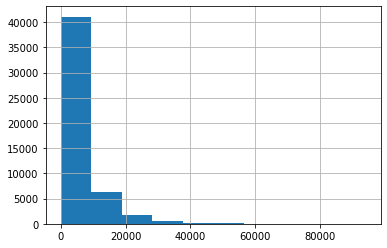

In [50]:
sub3['price'].hist()

In [52]:
import time
now = time.strftime("%m-%d_%H-%M", time.localtime())
sub3.to_csv('./sub/sub_'+now+'.csv',index=False)